In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from scipy.stats import norm
from sklearn.gaussian_process.kernels import Matern, RBF

## Capstone Project Strategy

We begin this guide by downloading the data:

In [5]:
X_org = np.load('initial_inputs.npy')
y_org = np.load('initial_outputs.npy')


In [6]:
run_1 = np.array([[0.000001, 0.999999],
                  [0.600000, 0.650000],
                  [0.273155, 0.341719],
                  [0.650000, 0.650000],
                  [0.650000, 0.690000],
                  [0.171717, 0.949494],
                  [0.757575, 0.888888]
                  ])
X=np.append(X_org, run_1, axis=0)
y=np.append(y_org, [0.000001, 
                    0.148576033908958, 
                    0.0810957169453553,
                    0.45545924408984,
                    0.405721165208293,
                    0.041578126839047075,
                    0.19749047514867124
                    ], axis=0)

### Random Search

The simplest solution would be a simple random search, that is, we can randomly choose our next query point.

This is used only for first two search - exploration.

In [7]:
next_query = np.random.uniform(size = 2)
print(next_query)

[0.97383731 0.27169427]


### Upper Confidence Bound

A second alternative would be to use Bayesian Optimization and consider an Upper Confidence Bound acquisition function: 

In [8]:
# Define Gaussian Process model
# Define Gaussian Process model with RBF kernel
kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True)

# gpr = GaussianProcessRegressor()

gpr.fit(X, y)

GaussianProcessRegressor(alpha=1e-06, kernel=1**2 * RBF(length_scale=1),
                         normalize_y=True)

In [9]:
# Define the acquisition function (Expected Improvement)
def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.01):
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample = gpr.predict(X_sample)
    
    mu_sample_opt = np.max(mu_sample)
    
    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0  # Ensure correct dimensions
    
    return ei

In [10]:
def upper_confidence_bound(X, gpr, kappa=2.5):
    mu, sigma = gpr.predict(X, return_std=True)
    ucb = mu + kappa * sigma
    return ucb

In [11]:
# to optimize the acquisition function, we will simply use gridsearch over a space of 10.000 gridpoints
x1 = np.linspace(0, 1, 100)
x2 = np.linspace(0, 1, 100)

In [12]:
X_grid = np.array([[x1_i, x2_j] for x1_i in x1 for x2_j in x2])
X_grid.shape

(10000, 2)

In [13]:
# Evaluate the acquisition function on the grid
ei = expected_improvement(X_grid, X, y, gpr)


In [14]:
# Find the next query point
next_query_ei = X_grid[np.argmax(ei)]
print('Next query point:', next_query_ei)

Next query point: [0.68686869 0.93939394]


In [15]:
# Evaluate the acquisition function on the grid
ucb = upper_confidence_bound(X_grid, gpr, kappa=2.5)

# Ensure correct shape for plotting
ucb = ucb.reshape(100, 100)

# Find the next query point
next_query = X_grid[np.argmax(ucb)]
print('Next query point:', next_query)

Next query point: [0.67676768 0.94949495]


## Visualizing our data and thinking of the problem

It is important when tackling problems to really think about the best strategy and to do some exploratory data analysis. Let's consider what we know about the problem:

1. From the hints, we expect two modes in the unknown function.

2. From the hints, we know that most of our queries should be zero!

3. The problem is two-dimensional.

4. The problem will have small length-scale (that is, we expect the modes to be very small)

From (3.) we can take advantage, and plot the initial data:

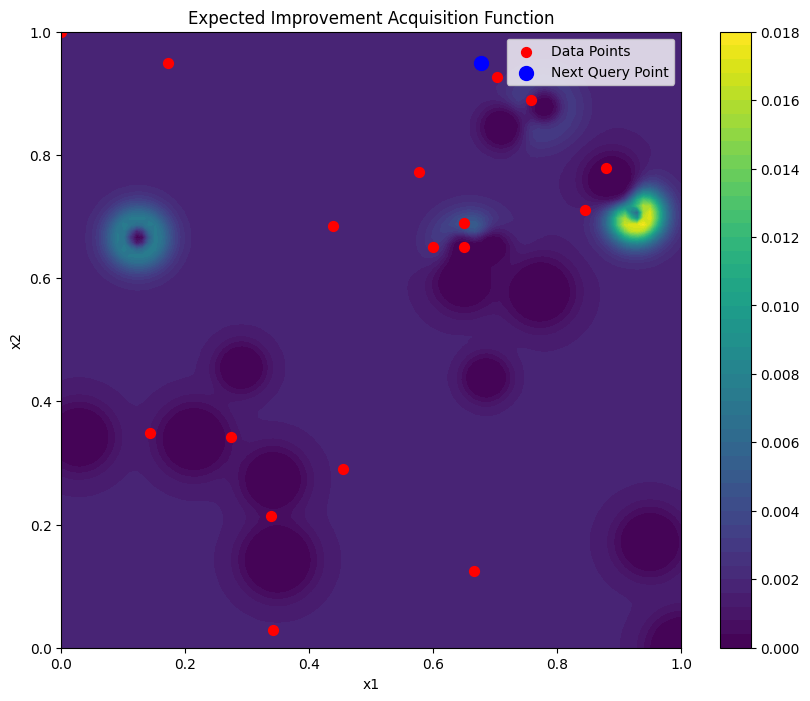

In [16]:
# Plot the acquisition function
plt.figure(figsize=(10, 8))
plt.contourf(x1, x2, ei.reshape(100, 100), levels=50, cmap='viridis')
plt.colorbar()
plt.scatter(X[:, 0], X[:, 1], c='red', s=50, label='Data Points')
plt.scatter(next_query[0], next_query[1], c='blue', s=100, label='Next Query Point')
plt.title('Expected Improvement Acquisition Function')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()

Doing this every week, we expect to be able to find the first of the two modes! This should would be enough to provide a good solution to the problem. To really verify if we found the maximum, we would need to find a second mode, however, we may be unlucky and simply never find it. This is an important part of Machine Learning: in theory we might want optimal, perfect solutions, but in practice most of the advancements can be done with simple solutions and careful consideration of the data available to us.

In [17]:
print(f"{str(next_query[0])[:8].ljust(8,'0')}-{str(next_query[1])[:8].ljust(8,'0')}")

0.676767-0.949494
